In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
df = pd.read_excel('data/competition_fcy1_fur1.xlsx')
df

,strain,mutant,dilution,replicate,count
0,LL13-040,fcy1,0.00100,1,0
1,LL13-040,fcy1,0.00010,1,3
2,LL13-040,fcy1,0.00001,1,8
3,LL13-040,fur1,0.00100,1,14
4,LL13-040,fur1,0.00010,1,13
5,LL13-040,fur1,0.00001,1,8
6,NC-02,fcy1,0.00100,1,0
7,NC-02,fcy1,0.00010,1,1
8,NC-02,fcy1,0.00001,1,6
9,NC-02,fur1,0.00100,1,16


In [3]:
LL13 = df[df.strain == 'LL13-040']
NC02 = df[df.strain == 'NC-02']

In [4]:
LL13ct = pd.crosstab(LL13['mutant'],LL13['dilution'], LL13['count'], aggfunc='sum')
NC02ct = pd.crosstab(NC02['mutant'],NC02['dilution'], NC02['count'], aggfunc='sum')
LL13ct

dilution,0.00001,0.00010,0.00100
mutant,,,
fcy1,18,11,0
fur1,14,21,30


In [5]:
chi2_info = []
chi2_info.append(stats.chi2_contingency(LL13ct)[:3])
stats.chi2_contingency(LL13ct)

Chi2ContingencyResult(statistic=23.247546419098143, pvalue=8.950750185787918e-06, dof=2, expected_freq=array([[ 9.87234043,  9.87234043,  9.25531915],
       [22.12765957, 22.12765957, 20.74468085]]))

In [6]:
chi2_info.append(stats.chi2_contingency(NC02ct)[:3])
stats.chi2_contingency(NC02ct)

Chi2ContingencyResult(statistic=12.943951612903225, pvalue=0.0015461677846807756, dof=2, expected_freq=array([[ 4.61702128,  4.76595745,  4.61702128],
       [26.38297872, 27.23404255, 26.38297872]]))

In [7]:
bardf = df.groupby(['strain','mutant','dilution'])[['count']].agg(['min','mean','max']).reset_index()
bardf['err'] = bardf[('count','mean')] - bardf[('count','min')]
bardf

strain mutant dilution count            err
                               min  mean max     
0   LL13-040   fcy1  0.00001     8   9.0  10  1.0
1   LL13-040   fcy1  0.00010     3   5.5   8  2.5
2   LL13-040   fcy1  0.00100     0   0.0   0  0.0
3   LL13-040   fur1  0.00001     6   7.0   8  1.0
4   LL13-040   fur1  0.00010     8  10.5  13  2.5
5   LL13-040   fur1  0.00100    14  15.0  16  1.0
6      NC-02   fcy1  0.00001     4   5.0   6  1.0
7      NC-02   fcy1  0.00010     1   2.0   3  1.0
8      NC-02   fcy1  0.00100     0   0.0   0  0.0
9      NC-02   fur1  0.00001    10  10.5  11  0.5
10     NC-02   fur1  0.00010    13  14.0  15  1.0
11     NC-02   fur1  0.00100    15  15.5  16  0.5

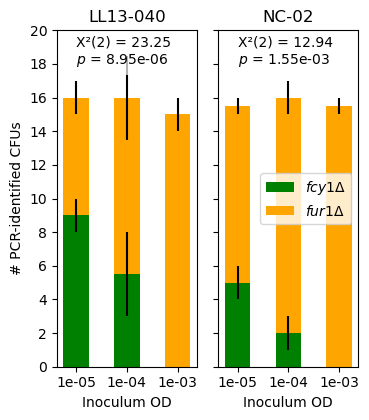

In [13]:
from matplotlib.ticker import StrMethodFormatter, MaxNLocator
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(3.8, 4.3))
xrange = np.arange(len(bardf.dilution.unique()))

ax0.yaxis.set_major_locator(MaxNLocator(integer=True))
ax0.set_ylim(None,20)

for i, s in enumerate(bardf.strain.unique()):
    fcy1df = bardf[(bardf.strain == s) & (bardf.mutant=='fcy1')]
    p1 = fig.axes[i].bar(xrange, fcy1df[('count','mean')],
                    width=0.5, color='green',
                    yerr=fcy1df['err'])
    
    fur1df = bardf[(bardf.strain == s) & (bardf.mutant=='fur1')]
    p2 = fig.axes[i].bar(xrange, fur1df[('count','mean')],
                    width=0.5, color='orange',
                    bottom=fcy1df[('count','mean')], yerr=fur1df['err'])
    
    fig.axes[i].set_xlabel('Inoculum OD')
    fig.axes[i].set_xticks(xrange,
                           ['{:.0e}'.format(x) for x in bardf.dilution.unique()],
                           #['10⁻⁵','10⁻⁴','10⁻³']
                          )
    t = fig.axes[i].text(0,18,"\u03A7"+f"²({chi2_info[i][2]}) = {chi2_info[i][0]:.2f}\n"
                     +u"$\it{p}$"+f" = {chi2_info[i][1]:.2e}"
                    )
    t.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))

ax0.title.set_text('LL13-040')
ax1.title.set_text('NC-02')
ax0.set_ylabel('# PCR-identified CFUs')
plt.legend((p1[0], p2[0]), (u'$\it{fcy1}$Δ', u'$\it{fur1}$Δ'), loc='center right')

plt.tight_layout()
plt.savefig('graphs/20230807_competition_fcy1_fur1.svg', format='svg', dpi=300)